In [1]:
push!(LOAD_PATH, pwd()*"/..")
import_path = "/Users/julian/Harvard/research/nowak/indirect_rec/src"
push!(LOAD_PATH, import_path)
using LightGraphs, Epidemics, GraphGeneration,IM
using GraphGeneration
using NLsolve
using PyPlot, Distributions
using DegreeDistribution
using StatsBase
using GraphCreation
using Clustering
using DataAnalysis
using TwoLevelGraphs

INFO: Recompiling stale cache file /Users/julian/.julia/lib/v0.5/Dierckx.ji for module Dierckx.
INFO: Recompiling stale cache file /Users/julian/.julia/lib/v0.5/PositiveFactorizations.ji for module PositiveFactorizations.
INFO: Recompiling stale cache file /Users/julian/.julia/lib/v0.5/NLsolve.ji for module NLsolve.

Use "Dict(a=>b for (a,b) in c)" instead.
INFO: Recompiling stale cache file /Users/julian/.julia/lib/v0.5/GSL.ji for module GSL.


0.08 0.04
  4.423581 seconds (89.06 M allocations: 1.928 GB, 4.88% gc time)


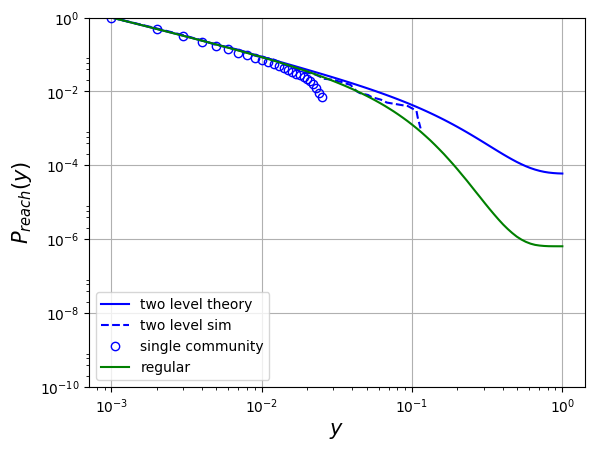

  0.840793 seconds (14.97 M allocations: 310.741 MB, 4.20% gc time)




























PyObject <matplotlib.legend.Legend object at 0x34125a550>

In [159]:
N = 1000 #1000
c_r = 0.2 #0.2
y_n = 0.5 #0.1

n_n = Int(N*y_n)#y_n*N
beta = get_beta(N,c_r,n_n)#4.0/(c_r*n_n)
alpha = get_alpha(N,c_r,n_n)#(N*beta)/n_n
# alpha,beta = 1.0,0.1

# alpha,beta = 0.0,0.0
# beta = 0.0
# alpha = 10


println(alpha," ", beta)
im_normal = InfectionModel(x -> 1 + alpha*x , x -> 1 + beta);



k = 25 #50
m = 25 #50#0.5: m=14,l=9,r=1 $ 0.3: m = 10, l = 7, r = 3
l = 24 #49
r = k -l
t = TwoLevel(Int(ceil(N/m)*m),m,l,r)

num_points = 100
@time yytl,pptl,s_eff_two_level = get_p_reach_theory(t,alpha,beta,N,true,num_points)

# N = Int(round(N/m))
yyr = logspace(log10(1/N),0,100)
im = InfectionModel(x -> 1 + beta + get_s_eff_exact(x,alpha,beta,k,N) , x -> 1 + beta)
# im = InfectionModel(x -> 1 + alpha*x , x -> 1 + beta)
ppr = P_reach_fast(im,N,1.0/N,yyr,true)
@time yys,pps = get_simulation_yy_pp(t,alpha,beta,1000)

loglog(yytl,pptl,"-b",label="two level theory")
loglog(yys,pps,"--b",label="two level sim")
yy,pp,pp_reverse = get_single_community_fixation(t,alpha,beta)
loglog(m/N*yy,pp,"ob",fillstyle="none",label="single community")
loglog(yyr,ppr,"-g",label="regular")
xlabel(L"$y$",size=15)
ylabel(L"$P_{reach}(y)$",size=15)
ylim([1e-10,1])
grid()
legend()

In [150]:
function get_simulation_yy_pp(t,alpha,beta,num_trials=100)
    im_normal = InfectionModel(x -> 1 + alpha*x , x -> 1 + beta);
    fixation_threshold = 1.0

    verbose = false
    ###Set to true if we want by-node information on infecteds (much more data!)
    carry_by_node_information = false
    graph_model = true
    in_parallel = true
    T = generate_regular_two_level_graph(t)
    graph_fn = () -> T 
    graph_data = TwoLevelGraph(LightGraphs.Graph(),t,get_clusters(t))
    graph_information = GraphInformation(graph_fn,Graph(),carry_by_node_information,graph_data)

    # @time runs = run_epidemics_parallel(num_trials,() -> run_epidemic_graph(N,im_normal,graph_information,fixation_threshold),in_parallel);
    # yy,pp = get_p_reach(runs)
    # yy /= N
    runs = run_epidemics_parallel(num_trials,() -> run_epidemic_graph_gillespie(t.N,im_normal,graph_information,fixation_threshold),in_parallel);
    yys,pps = get_p_reach(runs)
    yys /= N;
    return yys,pps
end


get_simulation_yy_pp (generic function with 2 methods)

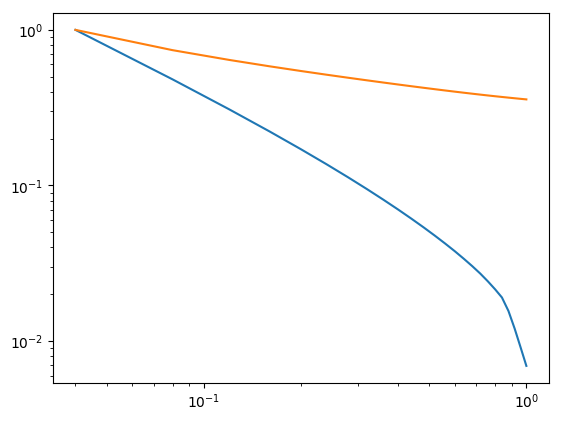

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x341354b10>

In [160]:
yy,pp,pp_reverse = get_single_community_fixation(t,alpha,beta)
#figure()
loglog(yy,pp)
loglog(yy,pp_reverse)

In [130]:
using Dierckx

function get_dmp_dmm(t,j,alpha,beta)
    i_orig = t.i
    t.i = i_orig + j 
    z_s = TwoLevelGraphs.get_y_local(t,j,true)
    z_sq_s = TwoLevelGraphs.get_y_squared_local(t,j,true)
    z_i = TwoLevelGraphs.get_y_local(t,j,false)
#     println("j: $j")
#     println("z_s: $(z_s)")
#     println("z_i: $(z_i)")
    println()

    y_i = j/m
    
    
    dmp = (1-y_i)*(z_s + alpha*z_sq_s)
    dmm = (y_i)*(1-z_i)*(1 + beta)
    
    if j == 0 || j == t.m
        dmm = 0 #j == 0
        dmp = 0 #j ==t.m
    end

    t.i = i_orig
    return dmp,dmm
end


function get_single_community_fixation(t,alpha,beta)
    y = 0.0
    t.i = t.N*y

    j_range = collect(0:t.m)
    y_range = j_range/t.m
    s_arr = zeros(Float64,j_range)
    dmp_arr = zeros(Float64,j_range)
    dmm_arr = zeros(Float64,j_range)
    s_plus_arr = zeros(Float64,j_range)
    for (idx,j) in enumerate(j_range)
        dmp,dmm = get_dmp_dmm(t,j,alpha,beta)
        s_arr[idx] = (dmp-dmm)
        s_plus_arr[idx] = (dmp+dmm)
        dmp_arr[idx] = dmp
        dmm_arr[idx] = dmm
    end

    # plot(j_range,s_arr./s_plus_arr)
    # plot(j_range,s_arr,"-")
#     plot(j_range,dmm_arr,"--")
#     plot(j_range,dmp_arr,"-")


    interpolation_order = 3
    s_fn(x) = evaluate(Spline1D(y_range,s_arr,k=interpolation_order,bc="extrapolate"),x)
    splus_fn(x) = evaluate(Spline1D(y_range,s_plus_arr,k=interpolation_order,bc="extrapolate"),x)

    s_m_fn(x) = evaluate(Spline1D(1-y_range[end:-1:1],-s_arr[end:-1:1],k=interpolation_order,bc="extrapolate"),x)

    
#     figure()
#     plot(y_range,s_fn(y_range))
#     plot(y_range,s_m_fn(y_range))
    yy = y_range[1:end]
    pp_reverse = P_reach_fast(s_m_fn,splus_fn,t.m,1.0/t.m,yy)
    pp = P_reach_fast(s_fn,splus_fn,t.m,1.0/t.m,yy)
    return yy,pp,pp_reverse
end

get_single_community_fixation (generic function with 1 method)

In [8]:

Spline1D(1-y_range[end:-1:1],-s_arr[end:-1:1],k=interpolation_order,bc="extrapolate")

Spline1D(knots=[0.0,0.04 … 0.96,1.0] (49 elements), k=3, extrapolation="extrapolate", residual=0.0)

We consider two regimes. In one the probability of one supernode becoming infected is equal as the probability of it becoming uninfected (starting with one of the opposite type, respectively). In that case the probability of infection is like a neutral process in supernode space.

In the opposite regime, where infection is much more likely than uninfection, the fixation probability is asymptotically the same as the fixation probability in just one supernode.